In [6]:
import os
import pandas as pd
import numpy as np
import datetime

In [7]:
directory_path = 'route_data_2'


csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]


routes = []

for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)
    parts = file.split('_')
    station_name = parts[0]
    df["Havaintoasema"] = station_name
    routes.append(df)
    print(f"Asema: {station_name} Reitit: {len(df)}")

Asema: Espoo Leppävaara Läkkisepänkuja Reitit: 1127
Asema: Harjavalta Pirkkala Reitit: 34
Asema: Helsinki Mannerheimintie Reitit: 0
Asema: Jyväskylä Jyskä Reitit: 140
Asema: Kaarina Kaarina Reitit: 314
Asema: Kuopio Maaherrankatu Reitit: 0
Asema: Lahti Laune Pohjoinen Liipolankatu Reitit: 98
Asema: Oulu Pyykkösjärvi Reitit: 109
Asema: Tampere Kaleva Reitit: 133
Asema: Vantaa Tikkurila Neilikkatie Reitit: 466


In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
route_df = pd.concat(routes)

In [9]:
directory_path = 'air_quality_data_2'


csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]


stations = []

for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)
    stations.append(df)

for station in stations:
    count_dashes = station['Hengitettävät hiukkaset <10 µm [µg/m3]'].str.count('-').sum()
    station["Date"] = station["Vuosi"].astype(str) + "-" + station["Kuukausi"].astype(str) + "-" +  station["Päivä"].astype(str) + " " + station["Aika [UTC]"]
    station["Date"] = pd.to_datetime(station["Date"])
    station = station.replace('-',np.NaN)
    station["Hengitettävät hiukkaset <10 µm [µg/m3]"] = station["Hengitettävät hiukkaset <10 µm [µg/m3]"].astype(float)

In [10]:
route_df["Havaintoasema"] = route_df["Havaintoasema"].replace("vantaa_hameenlinnanvayla", "Vantaa Hämeenlinnanväylä")
route_df["Havaintoasema"] = route_df["Havaintoasema"].replace("tampere_pirkankatu", "Tampere Pirkankatu")
route_df["Havaintoasema"] = route_df["Havaintoasema"].replace("jyvaskyla_hannikaisenkatu", "Jyväskylä Hannikaisenkatu")
route_df["Havaintoasema"] = route_df["Havaintoasema"].replace("kuopio_savilahti", "Kuopio Savilahti KYS")
route_df["Havaintoasema"] = route_df["Havaintoasema"].replace("helsinki_teollisuuskatu", "Helsinki Teollisuuskatu")
route_df["Havaintoasema"] = route_df["Havaintoasema"].replace("lahti_saimaankatu", "Lahti Saimaankatu")
route_df["Havaintoasema"] = route_df["Havaintoasema"].replace("pori_paanakedonkatu", "Pori Paanakedonkatu")
route_df["Havaintoasema"] = route_df["Havaintoasema"].replace("oulu_keskusta", "Oulu keskusta 2")
route_df["Havaintoasema"].value_counts()


Havaintoasema
Espoo Leppävaara Läkkisepänkuja       1127
Vantaa Tikkurila Neilikkatie           466
Kaarina Kaarina                        314
Jyväskylä Jyskä                        140
Tampere Kaleva                         133
Oulu Pyykkösjärvi                      109
Lahti Laune Pohjoinen Liipolankatu      98
Harjavalta Pirkkala                     34
Name: count, dtype: int64

In [11]:
route_df["endTime"] = pd.to_datetime(route_df["endTime"])

route_df['endTime'] = route_df['endTime'].dt.floor('H')

route_df['Date'] = route_df['endTime'].dt.strftime('%Y-%m-%d %H:00:00')

filter_df = route_df[["Havaintoasema", "Date", "1000m", "500m", "100m"]]


In [12]:
df_grouped = filter_df.groupby(["Havaintoasema", "Date"]).agg({
    '1000m': 'any',
    '500m': 'any',
    '100m': 'any'
}).reset_index()

df_grouped["Date"] = pd.to_datetime(df_grouped["Date"])
df_grouped

,Havaintoasema,Date,1000m,500m,100m
0,Espoo Leppävaara Läkkisepänkuja,2024-03-29 13:00:00,True,True,False
1,Espoo Leppävaara Läkkisepänkuja,2024-03-31 02:00:00,True,True,False
2,Espoo Leppävaara Läkkisepänkuja,2024-03-31 16:00:00,True,True,False
3,Espoo Leppävaara Läkkisepänkuja,2024-03-31 17:00:00,True,True,False
4,Espoo Leppävaara Läkkisepänkuja,2024-03-31 18:00:00,True,True,True
...,...,...,...,...,...
239,Vantaa Tikkurila Neilikkatie,2024-05-29 02:00:00,True,False,False
240,Vantaa Tikkurila Neilikkatie,2024-06-06 05:00:00,True,False,False
241,Vantaa Tikkurila Neilikkatie,2024-06-06 06:00:00,True,False,False
242,Vantaa Tikkurila Neilikkatie,2024-06-11 18:00:00,True,False,False


In [13]:
#Yhdistetään reittidata ja ilmanlaatudata
for i in range(10):
    stations[i] = pd.merge(stations[i], df_grouped, on=["Havaintoasema", "Date"], how="left")

In [14]:
#Täytetään NaN arvot ja muutetaan totuusarvot 1 ja 0 arvoiksi
for i in range(len(stations)):
    stations[i] = stations[i].applymap(lambda x: 1 if x is True else 0 if x is False or pd.isna(x) else x)

In [15]:
result = pd.concat(stations)

In [16]:
# result[(result["Havaintoasema"] == "Jyväskylä Hannikaisenkatu") & (result["Päivä"] == 1) & (result["Kuukausi"] == 5)]

In [17]:
# columns_to_shift = ['1000m', '500m', '100m']

result["Hengitettävät hiukkaset <10 µm [µg/m3]"] = result.groupby('Havaintoasema')["Hengitettävät hiukkaset <10 µm [µg/m3]"].shift(-1)

In [18]:
# result[(result["Havaintoasema"] == "Jyväskylä Hannikaisenkatu") & (result["Päivä"] == 1) & (result["Kuukausi"] == 5)]
result

,Havaintoasema,Vuosi,Kuukausi,Päivä,Aika [UTC],Hengitettävät hiukkaset <10 µm [µg/m3],Date,1000m,500m,100m
0,Espoo Leppävaara Läkkisepänkuja,2024,3,5,00:00,6.7,2024-03-05 00:00:00,0,0,0
1,Espoo Leppävaara Läkkisepänkuja,2024,3,5,01:00,5,2024-03-05 01:00:00,0,0,0
2,Espoo Leppävaara Läkkisepänkuja,2024,3,5,02:00,4.6,2024-03-05 02:00:00,0,0,0
3,Espoo Leppävaara Läkkisepänkuja,2024,3,5,03:00,4.3,2024-03-05 03:00:00,0,0,0
4,Espoo Leppävaara Läkkisepänkuja,2024,3,5,04:00,4,2024-03-05 04:00:00,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2562,Vantaa Tikkurila Neilikkatie,2024,6,19,19:00,9.7,2024-06-19 19:00:00,0,0,0
2563,Vantaa Tikkurila Neilikkatie,2024,6,19,20:00,12.2,2024-06-19 20:00:00,0,0,0
2564,Vantaa Tikkurila Neilikkatie,2024,6,19,21:00,10.3,2024-06-19 21:00:00,0,0,0
2565,Vantaa Tikkurila Neilikkatie,2024,6,19,22:00,4.6,2024-06-19 22:00:00,0,0,0


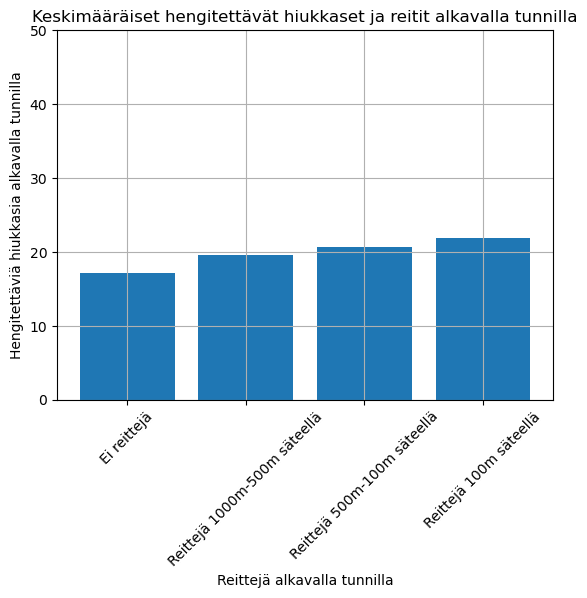

In [19]:
import matplotlib.pyplot as plt
result["Hengitettävät hiukkaset <10 µm [µg/m3]"] = result["Hengitettävät hiukkaset <10 µm [µg/m3]"].replace('-',np.NaN)
result["Hengitettävät hiukkaset <10 µm [µg/m3]"] = pd.to_numeric(result["Hengitettävät hiukkaset <10 µm [µg/m3]"])


result['booleans'] = result[['1000m', '500m', '100m']].sum(axis=1)

# Group the DataFrame based on the number of true distances
grouped = result.groupby('booleans')

# Calculate the mean of "Hengitettävät hiukkaset" for each group
mean_values = grouped["Hengitettävät hiukkaset <10 µm [µg/m3]"].mean()

# Plotting the results
plt.bar(mean_values.index, mean_values.values)
plt.xlabel("Reittejä alkavalla tunnilla")
plt.ylabel("Hengitettäviä hiukkasia alkavalla tunnilla")
plt.title("Keskimääräiset hengitettävät hiukkaset ja reitit alkavalla tunnilla")
plt.xticks([0,1, 2, 3], ['Ei reittejä', 'Reittejä 1000m-500m säteellä', 'Reittejä 500m-100m säteellä', 'Reittejä 100m säteellä'], rotation=45)
plt.grid()
plt.ylim(0,50)
plt.show()

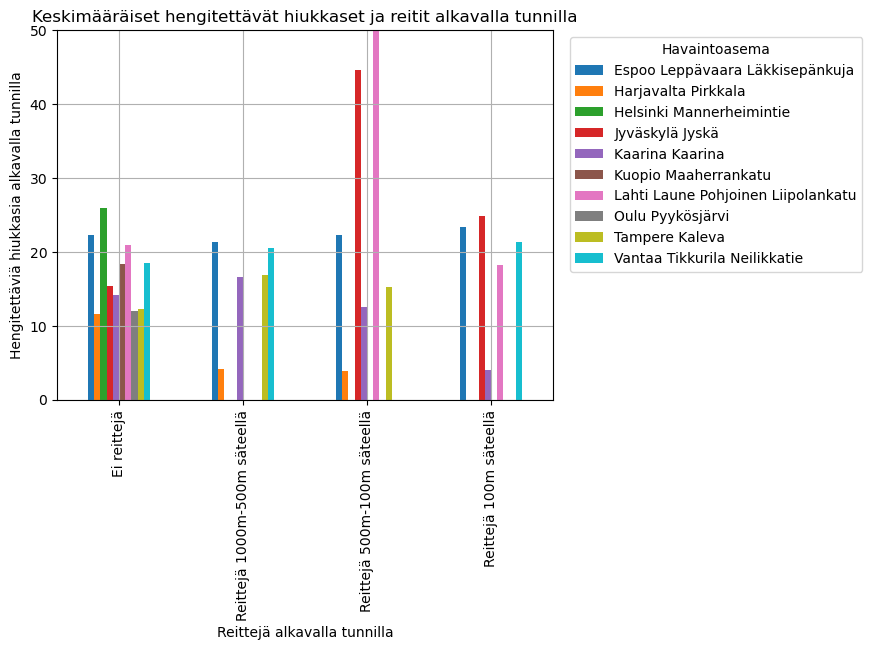

In [20]:
result['booleans'] = result[['1000m', '500m', '100m']].sum(axis=1)

# Group the DataFrame based on the number of true distances and Havaintoasema
grouped = result.groupby(['booleans', 'Havaintoasema'])

# Calculate the mean of "Hengitettävät hiukkaset" for each group
mean_values = grouped["Hengitettävät hiukkaset <10 µm [µg/m3]"].mean()

# Plotting the results
mean_values.unstack().plot(kind='bar')
plt.xlabel("Reittejä alkavalla tunnilla")
plt.ylabel("Hengitettäviä hiukkasia alkavalla tunnilla")
plt.title("Keskimääräiset hengitettävät hiukkaset ja reitit alkavalla tunnilla")
plt.xticks([0,1, 2, 3], ['Ei reittejä', 'Reittejä 1000m-500m säteellä', 'Reittejä 500m-100m säteellä', 'Reittejä 100m säteellä'])
plt.legend(title="Havaintoasema", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid()
plt.ylim(0,50)
plt.show()

In [21]:
shifted = result.copy()
shifted["Hengitettävät hiukkaset <10 µm [µg/m3]"] = shifted.groupby('Havaintoasema')["Hengitettävät hiukkaset <10 µm [µg/m3]"].shift(-1)

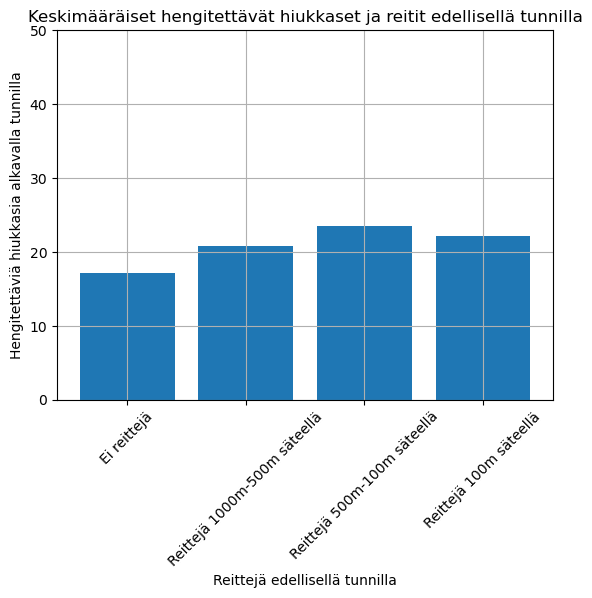

In [22]:
shifted['booleans'] = shifted[['1000m', '500m', '100m']].sum(axis=1)

# Group the DataFrame based on the number of true distances
grouped = shifted.groupby('booleans')

# Calculate the mean of "Hengitettävät hiukkaset" for each group
mean_values = grouped["Hengitettävät hiukkaset <10 µm [µg/m3]"].mean()

# Plotting the results
plt.bar(mean_values.index, mean_values.values)
plt.xlabel("Reittejä edellisellä tunnilla")
plt.ylabel("Hengitettäviä hiukkasia alkavalla tunnilla")
plt.title("Keskimääräiset hengitettävät hiukkaset ja reitit edellisellä tunnilla")
plt.xticks([0,1, 2, 3], ['Ei reittejä', 'Reittejä 1000m-500m säteellä', 'Reittejä 500m-100m säteellä', 'Reittejä 100m säteellä'], rotation=45)
plt.grid()
plt.ylim(0,50)
plt.show()

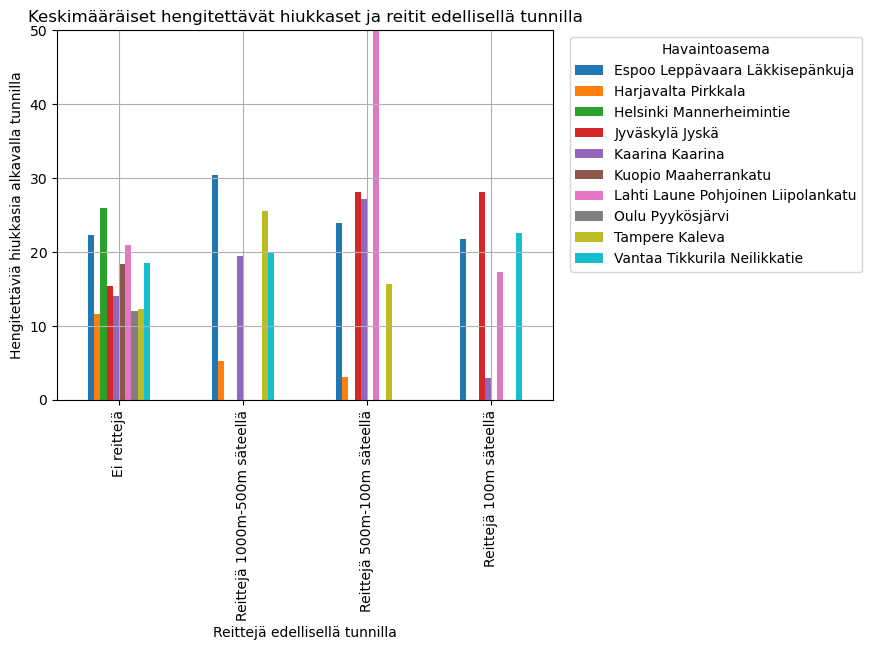

In [23]:
shifted['booleans'] = shifted[['1000m', '500m', '100m']].sum(axis=1)

# Group the DataFrame based on the number of true distances and Havaintoasema
grouped = shifted.groupby(['booleans', 'Havaintoasema'])

# Calculate the mean of "Hengitettävät hiukkaset" for each group
mean_values = grouped["Hengitettävät hiukkaset <10 µm [µg/m3]"].mean()

# Plotting the results
mean_values.unstack().plot(kind='bar')
plt.xlabel("Reittejä edellisellä tunnilla")
plt.ylabel("Hengitettäviä hiukkasia alkavalla tunnilla")
plt.title("Keskimääräiset hengitettävät hiukkaset ja reitit edellisellä tunnilla")
plt.xticks([0,1, 2, 3], ['Ei reittejä', 'Reittejä 1000m-500m säteellä', 'Reittejä 500m-100m säteellä', 'Reittejä 100m säteellä'])
plt.legend(title="Havaintoasema", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid()
plt.ylim(0,50)
plt.show()

In [24]:
daily = result.copy()

daily['Date'] = pd.to_datetime(daily['Date']).dt.date

daily = daily.groupby(["Date", "Havaintoasema"]).agg({
    "1000m": "sum",
    "500m": "sum",
    "100m": "sum",
    "Hengitettävät hiukkaset <10 µm [µg/m3]": "mean"
}).reset_index()


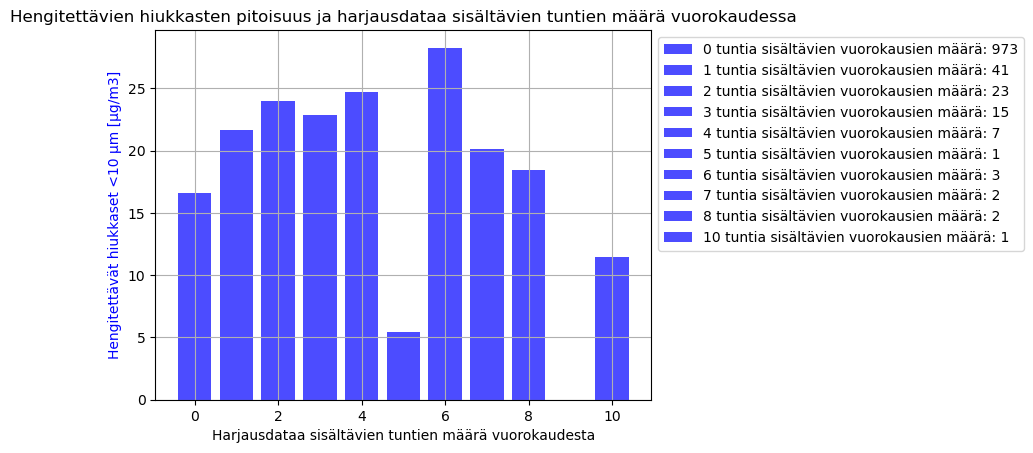

In [25]:
grouped_df = daily.groupby("1000m")["Hengitettävät hiukkaset <10 µm [µg/m3]"].agg(['mean', 'count']).reset_index()


fig, ax1 = plt.subplots()


bars = ax1.bar(grouped_df["1000m"], grouped_df["mean"], color='b', alpha=0.7, label='Mean')
ax1.set_xlabel("Harjausdataa sisältävien tuntien määrä vuorokaudesta")
ax1.set_ylabel("Hengitettävät hiukkaset <10 µm [µg/m3]", color='b')


legend_labels = []
for i, (bar, count, m_1000m) in enumerate(zip(bars, grouped_df["count"], grouped_df["1000m"])):
    legend_labels.append(f"{m_1000m} tuntia sisältävien vuorokausien määrä: {count}")


ax1.legend(bars, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.title("Hengitettävien hiukkasten pitoisuus ja harjausdataa sisältävien tuntien määrä vuorokaudessa")
plt.grid()
plt.show()

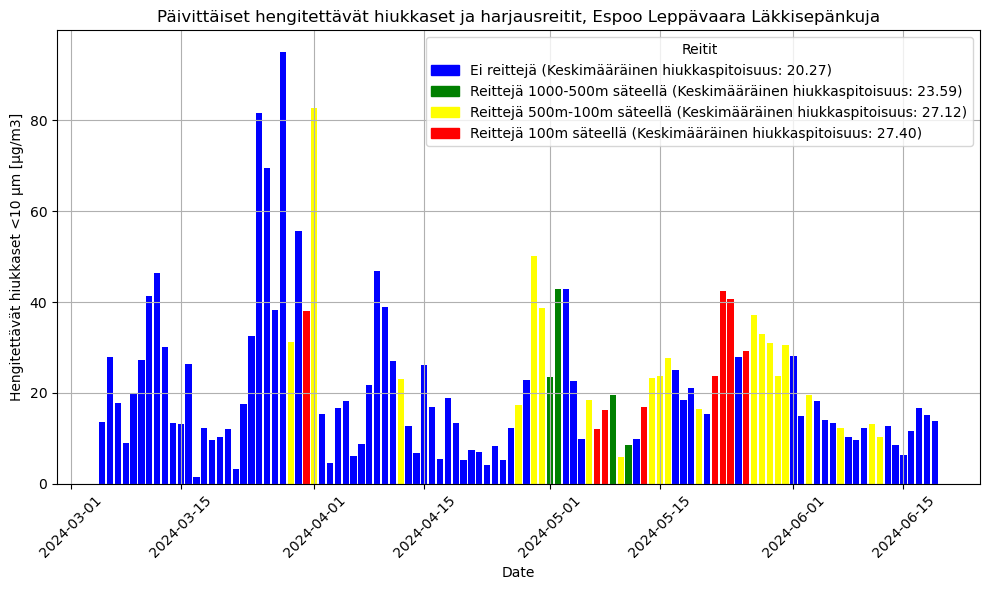

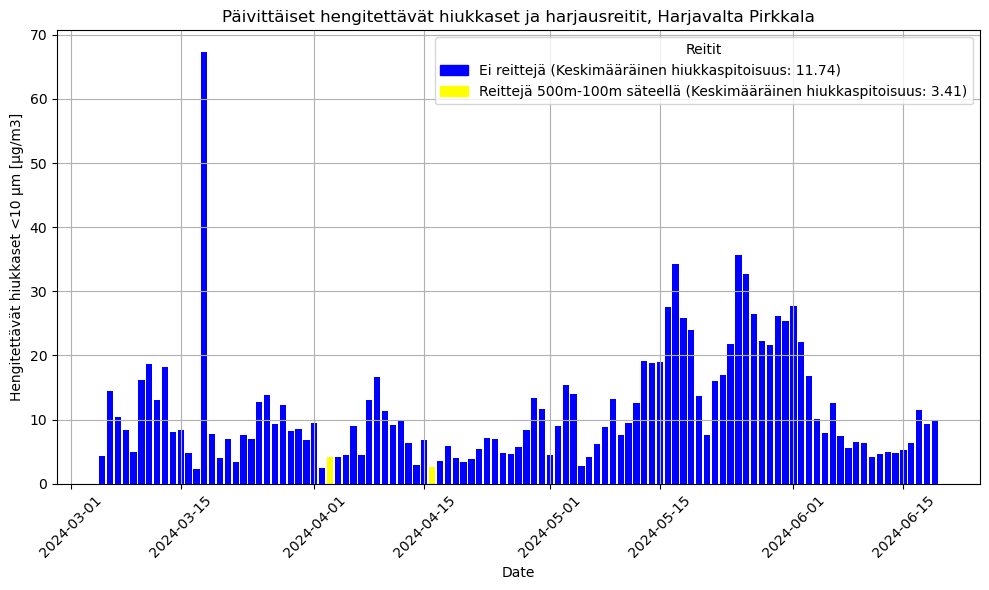

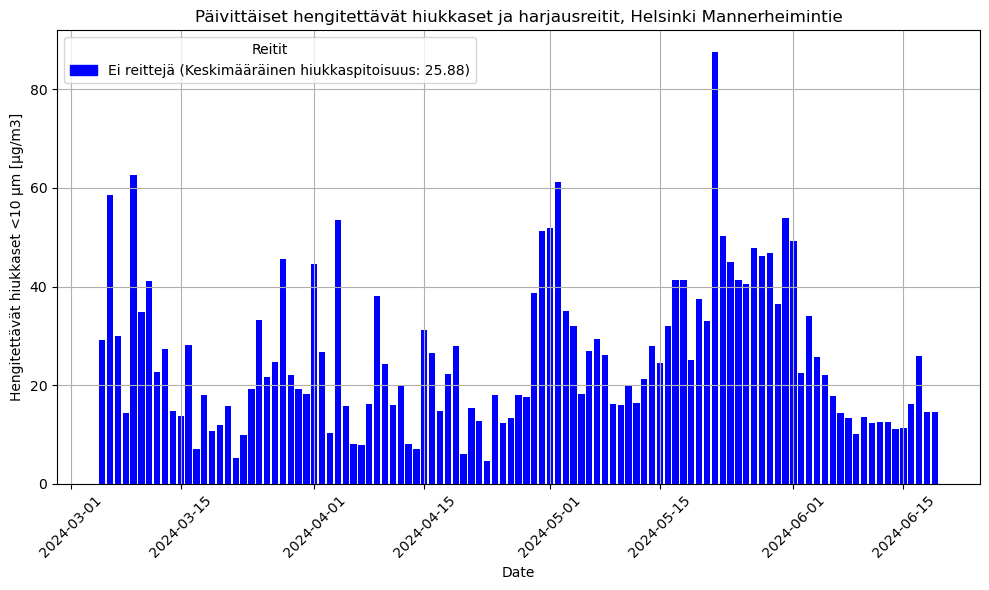

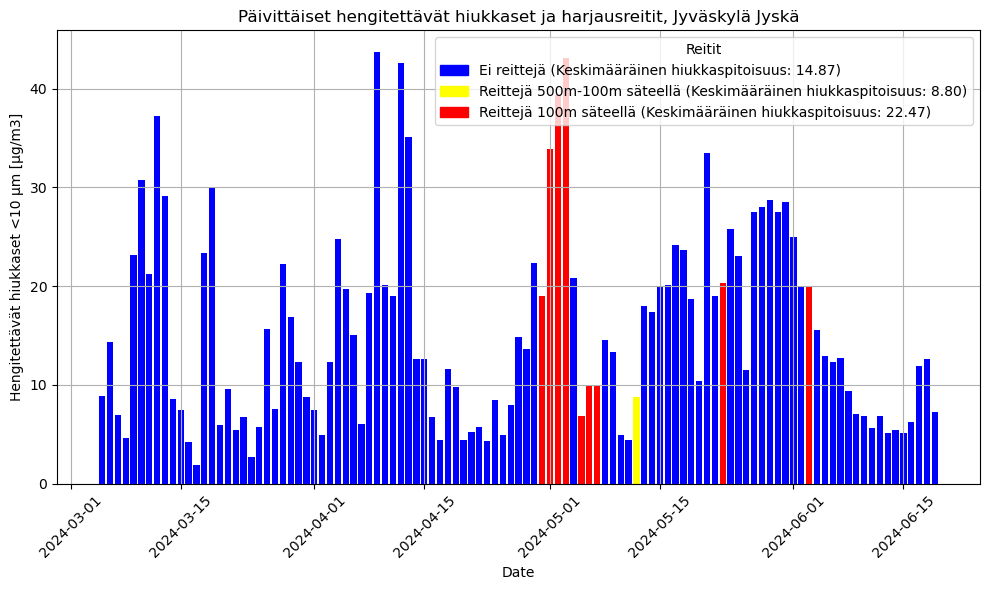

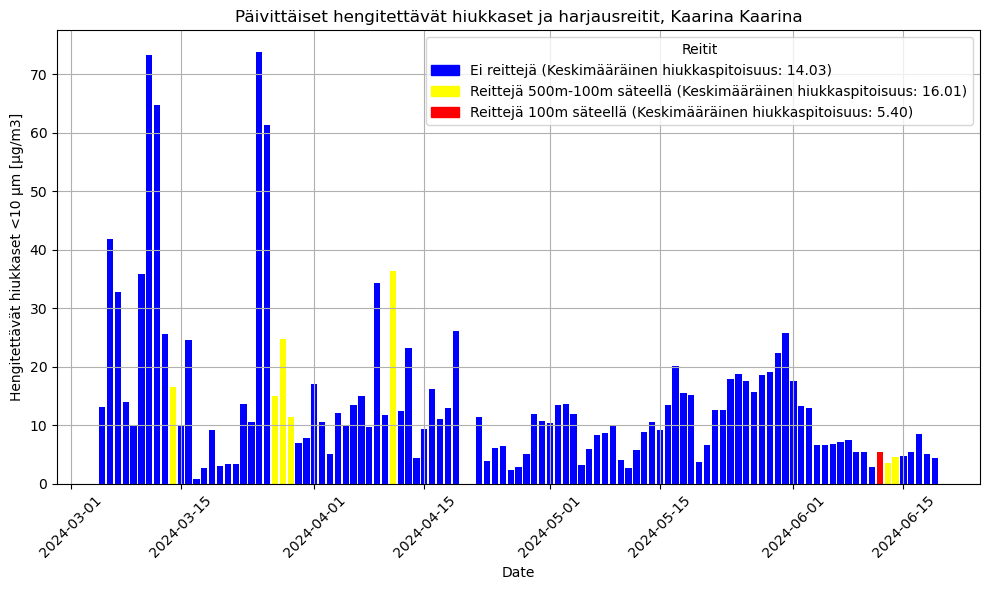

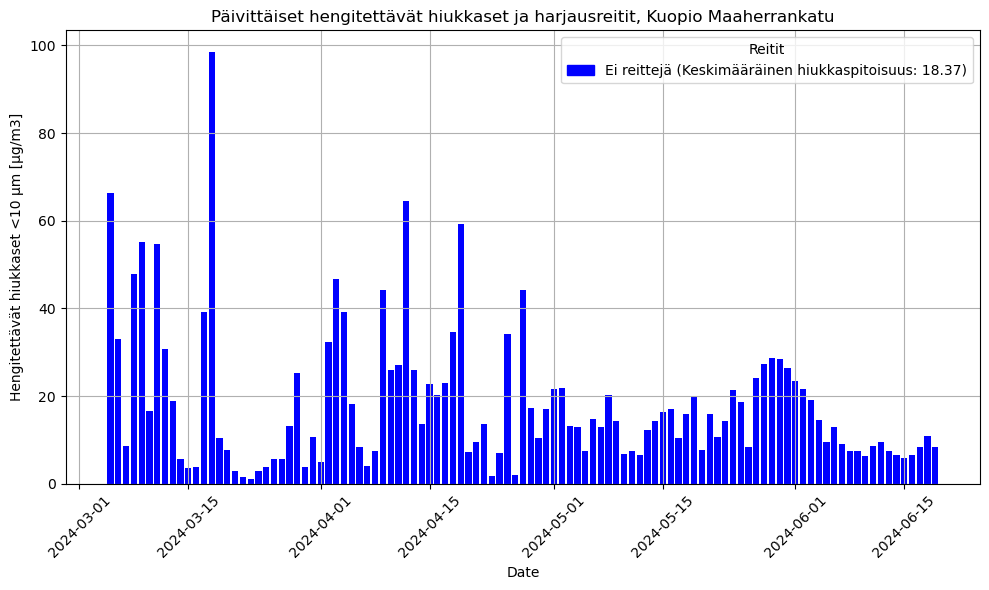

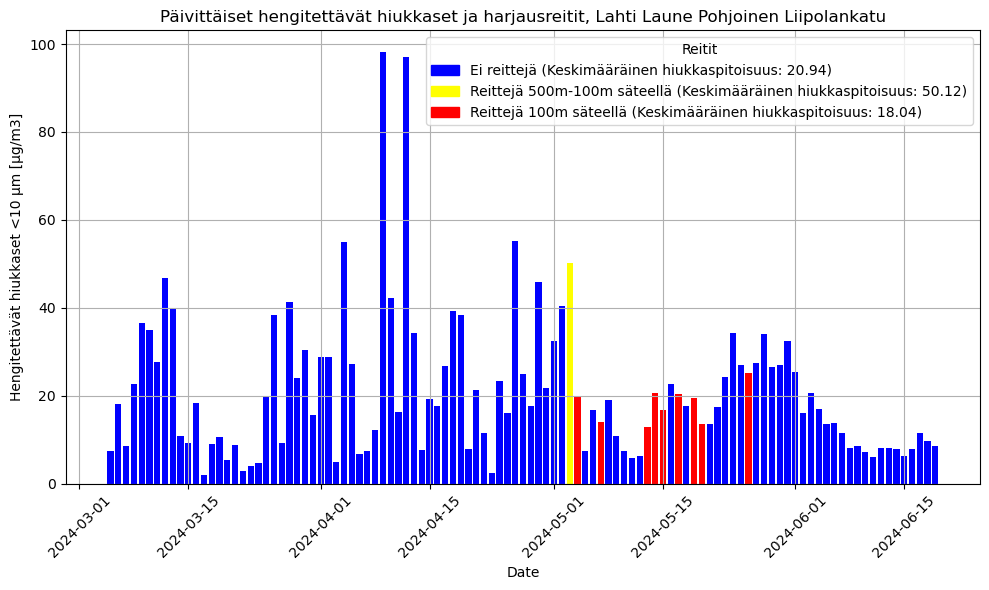

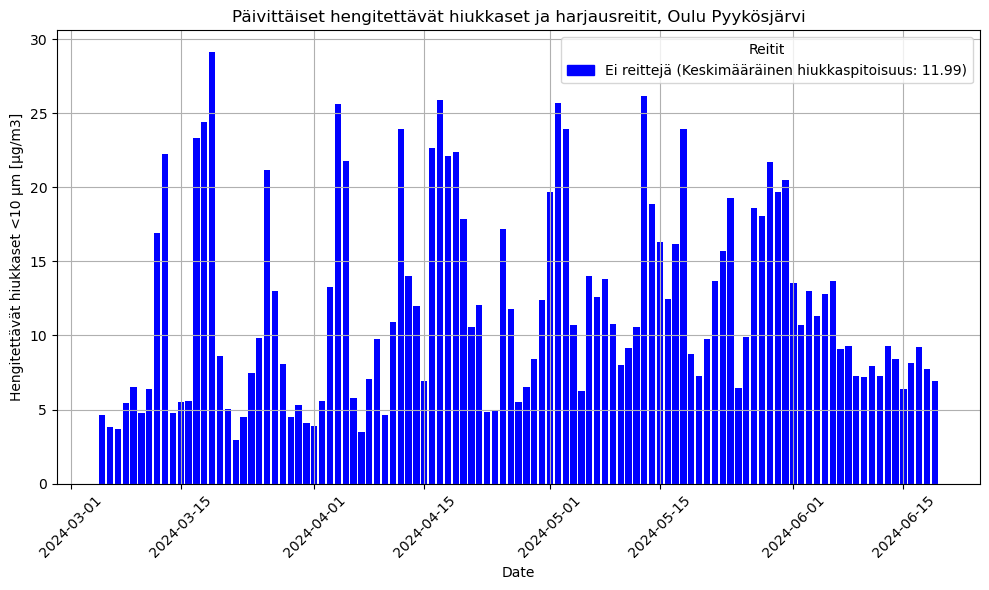

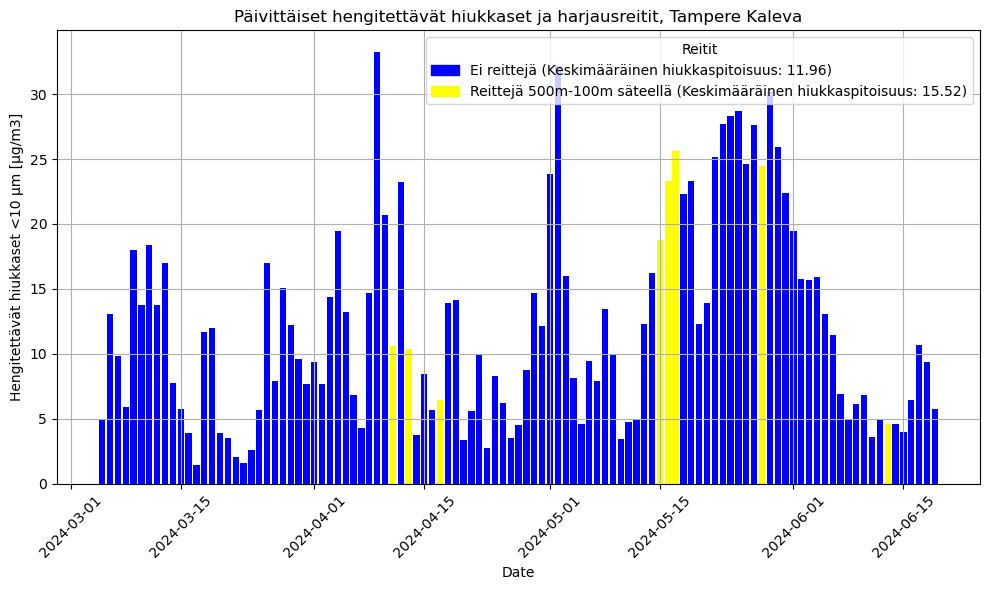

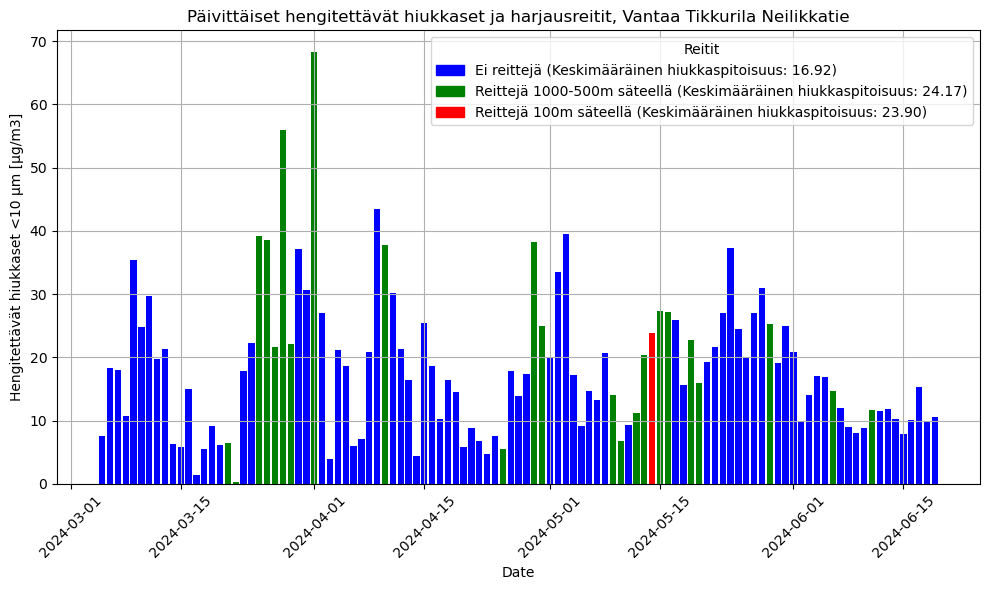

In [26]:
daily['Alueet'] = (daily[['1000m', '500m', '100m']] > 0).sum(axis=1)
df = daily.copy()
from matplotlib.patches import Patch


color_map = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red'}

weather_stations = df['Havaintoasema'].unique()

def return_distance(num):
    if num == 0:
        return "Ei reittejä"
    if num == 1:
        return "Reittejä 1000-500m säteellä"
    if num == 2:
        return "Reittejä 500m-100m säteellä"
    if num == 3:
        return "Reittejä 100m säteellä"

# Plotting
for station in weather_stations:
    station_df = df[df['Havaintoasema'] == station]
    mean_values = station_df.groupby('Alueet')['Hengitettävät hiukkaset <10 µm [µg/m3]'].mean()
    legend_labels = {distance: f'{return_distance(distance)} (Keskimääräinen hiukkaspitoisuus: {mean_value:.2f})' 
                     for distance, mean_value in mean_values.items()}
    legend_patches = [Patch(color=color_map[distance], label=legend_labels[distance]) 
                      for distance in legend_labels]
    colors = station_df['Alueet'].map(color_map)
    plt.figure(figsize=(10, 6))
    plt.bar(station_df['Date'], station_df['Hengitettävät hiukkaset <10 µm [µg/m3]'], color=colors)
    plt.xlabel('Date')
    plt.ylabel('Hengitettävät hiukkaset <10 µm [µg/m3]')
    plt.title(f'Päivittäiset hengitettävät hiukkaset ja harjausreitit, {station}')
    plt.xticks(rotation=45)
    plt.legend(handles=legend_patches, title="Reitit")
    plt.tight_layout()
    plt.grid()
    plt.show()



In [27]:
hourly = result.copy()
hourly = hourly.rename(columns={"booleans":"Alueet"})
hourly["Alueet"].value_counts()

Alueet
0    25454
2       97
1       79
3       47
Name: count, dtype: int64

In [28]:
daily["Alueet"].value_counts()

Alueet
0    975
2     40
3     28
1     27
Name: count, dtype: int64

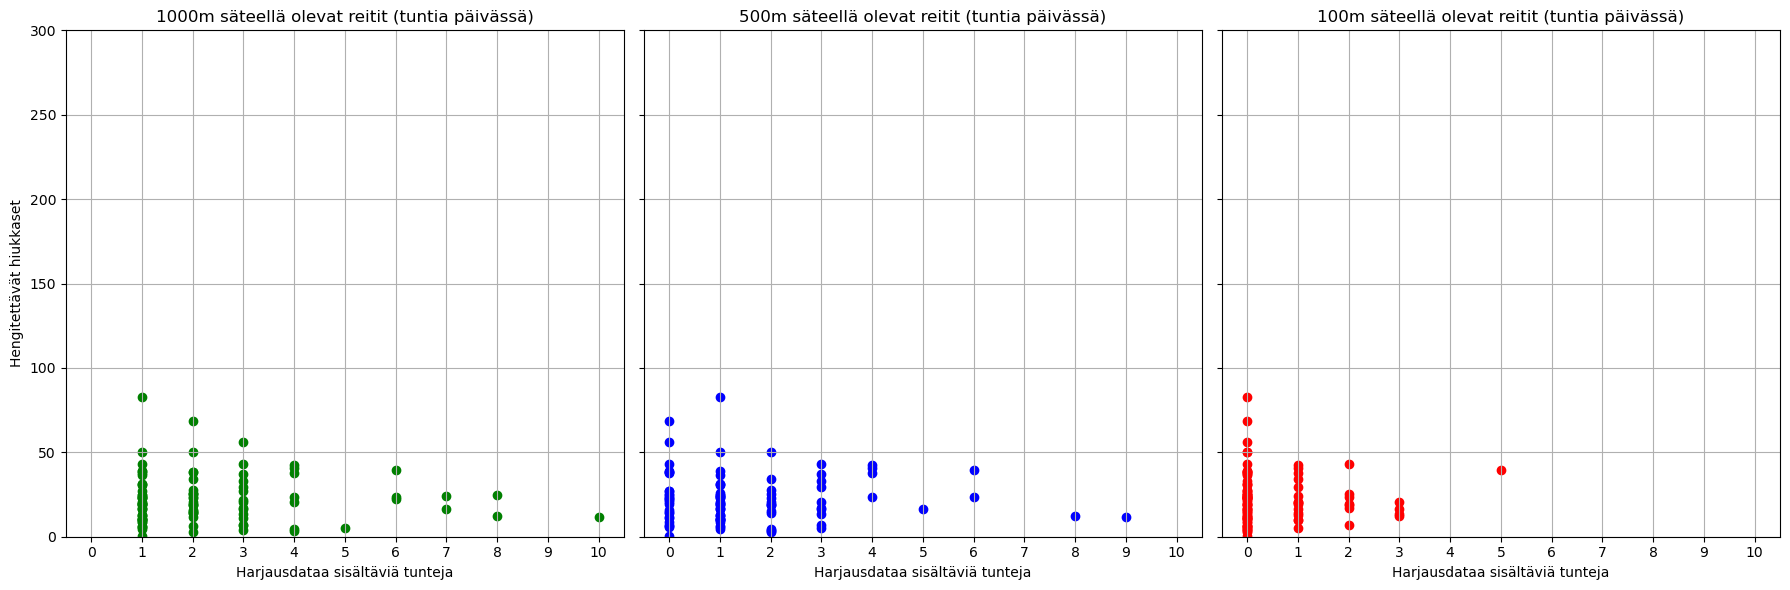

In [29]:
df = daily.copy()

df = df[df["Alueet"] > 0]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True, sharex=True)
axes[0].scatter(df['1000m'], df['Hengitettävät hiukkaset <10 µm [µg/m3]'], color='green')
axes[0].set_title('1000m säteellä olevat reitit (tuntia päivässä)')
axes[0].set_xlabel('Harjausdataa sisältäviä tunteja')
axes[0].set_ylabel('Hengitettävät hiukkaset')
axes[0].grid()

axes[1].scatter(df['500m'], df['Hengitettävät hiukkaset <10 µm [µg/m3]'], color='blue')
axes[1].set_title('500m säteellä olevat reitit (tuntia päivässä)')
axes[1].set_xlabel('Harjausdataa sisältäviä tunteja')
axes[1].grid()

axes[2].scatter(df['100m'], df['Hengitettävät hiukkaset <10 µm [µg/m3]'], color='red')
axes[2].set_title('100m säteellä olevat reitit (tuntia päivässä)')
axes[2].set_xlabel('Harjausdataa sisältäviä tunteja')
axes[2].grid()

plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.ylim(0,300)
plt.tight_layout()
plt.show()

# Sisältää vain harjausdataa sisältävät päivät

In [30]:
import statsmodels.api as sm


X = df[['Alueet']]
y = df['Hengitettävät hiukkaset <10 µm [µg/m3]']
X = sm.add_constant(X)  


model = sm.OLS(y, X).fit()
print(model.summary())

                                      OLS Regression Results                                      
Dep. Variable:     Hengitettävät hiukkaset <10 µm [µg/m3]   R-squared:                       0.003
Model:                                                OLS   Adj. R-squared:                 -0.007
Method:                                     Least Squares   F-statistic:                    0.3101
Date:                                    Mon, 24 Jun 2024   Prob (F-statistic):              0.579
Time:                                            14:46:10   Log-Likelihood:                -387.40
No. Observations:                                      95   AIC:                             778.8
Df Residuals:                                          93   BIC:                             783.9
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
          

In [34]:
df = hourly.copy()

df.to_csv("hourly2.csv",index=False)

In [32]:
df = hourly.copy()

df

,Havaintoasema,Vuosi,Kuukausi,Päivä,Aika [UTC],Hengitettävät hiukkaset <10 µm [µg/m3],Date,1000m,500m,100m,Alueet
0,Espoo Leppävaara Läkkisepänkuja,2024,3,5,00:00,6.7,2024-03-05 00:00:00,0,0,0,0
1,Espoo Leppävaara Läkkisepänkuja,2024,3,5,01:00,5.0,2024-03-05 01:00:00,0,0,0,0
2,Espoo Leppävaara Läkkisepänkuja,2024,3,5,02:00,4.6,2024-03-05 02:00:00,0,0,0,0
3,Espoo Leppävaara Läkkisepänkuja,2024,3,5,03:00,4.3,2024-03-05 03:00:00,0,0,0,0
4,Espoo Leppävaara Läkkisepänkuja,2024,3,5,04:00,4.0,2024-03-05 04:00:00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2562,Vantaa Tikkurila Neilikkatie,2024,6,19,19:00,9.7,2024-06-19 19:00:00,0,0,0,0
2563,Vantaa Tikkurila Neilikkatie,2024,6,19,20:00,12.2,2024-06-19 20:00:00,0,0,0,0
2564,Vantaa Tikkurila Neilikkatie,2024,6,19,21:00,10.3,2024-06-19 21:00:00,0,0,0,0
2565,Vantaa Tikkurila Neilikkatie,2024,6,19,22:00,4.6,2024-06-19 22:00:00,0,0,0,0


In [33]:
daily[daily["1000m"] > 3]

,Date,Havaintoasema,1000m,500m,100m,Hengitettävät hiukkaset <10 µm [µg/m3],Alueet
234,2024-03-28,Kaarina Kaarina,8,1,0,24.783333,2
244,2024-03-29,Kaarina Kaarina,10,9,0,11.425000,2
249,2024-03-29,Vantaa Tikkurila Neilikkatie,6,0,0,22.145833,1
260,2024-03-31,Espoo Leppävaara Läkkisepänkuja,4,4,1,37.926087,3
583,2024-05-02,Jyväskylä Jyskä,6,6,5,39.350000,3
630,2024-05-07,Espoo Leppävaara Läkkisepänkuja,8,8,3,12.112500,3
640,2024-05-08,Espoo Leppävaara Läkkisepänkuja,7,5,3,16.304167,3
699,2024-05-13,Vantaa Tikkurila Neilikkatie,4,0,0,20.333333,1
709,2024-05-14,Vantaa Tikkurila Neilikkatie,7,1,1,23.895833,3
728,2024-05-16,Tampere Kaleva,6,6,0,23.320833,2
